# 📓 Notebook 5: Clustering
In this notebook, we apply unsupervised **clustering** techniques to air quality data collected in Taiwan between 2016 and 2024 and included in **Taiwan Air Quality Index Data 2016~2024** dataset.

## Roadmap
- Load and clean the dataset (handle missing values, remove irrelevant variables).
- Apply KMeans clustering to group observations into homogeneous clusters.
- Reduce dimensionality with PCA (Principal Component Analysis) to visualize clusters in two dimensions.
- Compare the resulting clusters with the status label present in the dataset (even though KMeans does not use it directly).


## Clustering vs Neural Network
- In the previous notebook considering 3. Decision Tree and 4. Neural Network we formulated a supervised classification problem: the model receives measurements as input and directly returns the status label.
- In clustering, instead, we tackle an unsupervised learning problem:
  - we do not use the status label to build the clusters.
  - the algorithm identifies groups based solely on numerical data similarity.
- later, we can compare the clusters with the label *status* to assess whether the available features allow for good class separation.






## 1. Initial Setup
In this section, we import the libraries required for file handling, data analysis and visualization, and machine learning techniques.
This prepares the environment in a consistent and reproducible way, allowing us to load the data, preprocess it, apply clustering, and evaluate the results.

**Tools Used**
- File system: os.
- Data analysis: pandas, numpy.
- Visualization: matplotlib; custom legends matplotlib.patches and matplotlib.lines.Line2D.
- Colormaps: matplotlib.colors.ListedColormap and matplotlib.cm.
- Preprocessing: StandardScaler (scaling of numerical features).
- Clustering: KMeans (unsupervised clustering algorithm).
- Dimensionality Reduction: PCA (dimensionality reduction to visualize clusters in 2D).
- Metrics: silhouette_score (evaluation of cluster quality).

In [1]:
# Import of libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.utils import check_random_state



### Loading the Dataset

- Load the CSV file containing air quality data


In [3]:
from google.colab import drive
drive.mount('/content/drive')

cwd = 'drive/MyDrive/' # Set your current working directory where the csv file is located

# Check if file exists
file_path = cwd + 'es_python/air_quality.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"The CSV file was not found at the path: {file_path}")

# Load dataset (first 1,000,000 rows for testing)
df = pd.read_csv(file_path, low_memory=False, na_values=['-', 'NA', 'n/a', 'ND',''], nrows=1000000)

Mounted at /content/drive


## 2. Data Cleaning

Before applying clustering, it is essential to prepare the data.
An algorithm like KMeans relies on (Euclidean) distances and can be heavily influenced by noisy data or irrelevant variables.

In [4]:
# Let's check that the column type has been read correctly
print(df.dtypes)

# display the first 5 rows
df.head()

date          object
sitename      object
county        object
aqi          float64
pollutant     object
status        object
so2          float64
co           float64
o3           float64
o3_8hr       float64
pm10         float64
pm2.5        float64
no2          float64
nox          float64
no           float64
windspeed    float64
winddirec    float64
unit         float64
co_8hr       float64
pm2.5_avg    float64
pm10_avg     float64
so2_avg      float64
longitude    float64
latitude     float64
siteid       float64
dtype: object


,date,sitename,county,aqi,pollutant,status,so2,co,o3,o3_8hr,...,windspeed,winddirec,unit,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2024-08-31 23:00,Hukou,Hsinchu County,62.0,PM2.5,Moderate,0.9,0.17,35.0,40.2,...,2.3,225.0,NaN,0.2,20.1,26.0,1.0,121.038869,24.900097,22.0
1,2024-08-31 23:00,Zhongming,Taichung City,50.0,NaN,Good,1.6,0.32,27.9,35.1,...,1.1,184.0,NaN,0.2,15.3,23.0,1.0,120.641092,24.151958,31.0
2,2024-08-31 23:00,Zhudong,Hsinchu County,45.0,NaN,Good,0.4,0.17,25.1,40.6,...,0.4,210.0,NaN,0.2,13.8,24.0,0.0,121.088955,24.740914,23.0
3,2024-08-31 23:00,Hsinchu,Hsinchu City,42.0,NaN,Good,0.8,0.20,30.0,35.9,...,1.9,239.0,NaN,0.2,13.0,26.0,1.0,120.972368,24.805636,24.0
4,2024-08-31 23:00,Toufen,Miaoli County,50.0,NaN,Good,1.0,0.16,33.5,35.9,...,1.8,259.0,NaN,0.1,15.3,28.0,1.0,120.898693,24.696907,25.0


### Preparation for Clustering

- Missing Values Check to quickly identify columns with quality issues.
- Removal of Irrelevant Columns, we drop descriptive or identifying variables (sitename, county, aqi, etc.) they do not provide numerical information, or they are directly linked to status (e.g., aqi), which would create an unrealistic shortcut.
- Handling Missing Values, we remove empty columns and incomplete rows: in a didactic context, we prefer a clean dataset, even though in practice imputation techniques could be used.
- Checking the status Column, we drop rows where the label is missing.
- Defining the Number of Clusters (k), we set it equal to the number of distinct values in status.
This does not mean we use status for clustering, but only as a reference to tell the model how many clusters to form.

**Goal**

To obtain a clean numerical dataset, with all variables ready for analysis, and to know how many clusters we will build with KMeans.




In [5]:
# Let's remove the unnecessary columns
df = df.drop(columns=["sitename", "county", 'aqi',"siteid","pollutant","date"])

#  Drops any column that contains only missing values
df = df.dropna(axis=1, how="all")

# Drops any row that has at least one missing value in any remaining column
df = df.dropna(axis=0, how="any")

# Show the distinct values of the 'status' column
print(df['status'].unique())

# Show number of distinct values of the 'status' column
print("Different values:", df['status'].nunique())

['Moderate' 'Good' 'Unhealthy for Sensitive Groups' 'Unhealthy'
 'Very Unhealthy']
Different values: 5


- KMeans requires only numerical values.
Therefore, we extract only the numerical columns from the dataset, excluding status, which is used only as a reference.

**Standardization with StandardScaler**
- In KMeans, Euclidean distances are crucial
if one variable has very large values and another very small values
the former may dominate the latter.
Scaling brings all variables to have mean = 0 and standard deviation = 1,
making them comparable.

In [6]:
# Select only the numerical columns for the scaler
df_numeric = df.select_dtypes(include=[np.number])

# Fit the scaler on the full numeric data and transform it to a NumPy array
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_numeric)

## 3. Choosing the Number of Clusters
- There are several methods to determine the optimal number of clusters to use with KMeans while other approaches to clustering automatically chose the best number of clusters
  - In our case, this analysis is not necessary.

In the following we can see a code snippet reporting a possible solution.

⚠ We will not use this code.

In [9]:
# Silhouette-based model selection for K (number of clusters)
scores = {}

# Try different k values and compute the silhouette score on the sampled subset
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    score = silhouette_score(df_scaled,labels)
    scores[k] = score
    print(f"Silhouette score for k={k}: {score:.4f}")

# Pick the k with the highest silhouette score
best_k = max(scores, key=scores.get)
print(f"\nAccording to the silhouette analysis, the optimal number of clusters would be: k={best_k}")

KeyboardInterrupt: 


## 4. Clustering with KMeans
- We now apply the KMeans algorithm, asking it to form `num_clusters` groups.
The algorithm assigns each record a numeric label indicating its cluster membership.

In [ ]:
# Count how many unique labels/classes are present in 'status'
num_clusters = df['status'].nunique()

# Create a KMeans model with k = num_clusters clusters.
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# Fit the model on the standardized numeric features and assign each sample to its nearest centroid.
labels = kmeans.fit_predict(df_scaled)

## 5. Comparison Between Clusters and the status Variable
In this section, we compare the clusters obtained with the actual status labels.

**What the Code Does**

Using `pd.crosstab`, we create a matrix that shows how status values are distributed across clusters:
- Rows = actual classes (status)
- Columns = clusters found by KMeans
This helps us understand, for each real class, which clusters the observations fall into.
- Cluster --> Status Mapping.
Each cluster is associated with the most frequent status within it (majority rule).
This allows us to “translate” a cluster into a status prediction.

**Status Predictions**

We convert cluster labels into their corresponding status values and compare them with the actual ones.

**Prediction Evaluation**
- For each status, we count how many observations were correctly or incorrectly classified.
- We calculate the accuracy % for each class.
- We compute the overall accuracy as the average across all observations.


In [ ]:
# Build a contingency table between the true labels ('status')
# and the unsupervised cluster assignments 'labels'.
ct = pd.crosstab(df['status'], labels, colnames=['cluster'])
print("Contingency: status vs cluster")
display(ct)

# For each cluster, pick the most frequent 'status'.
# This yields a majority-vote mapping: cluster_id --> predicted status label.
cluster_to_status = ct.idxmax(axis=0).to_dict()
print("Mapping cluster --> status:", cluster_to_status)

# Convert each sample's cluster id into a predicted status via the majority-vote mapping.
# Align the Series index with df to keep row order consistent.
pred_status = pd.Series(labels, index=df.index).map(cluster_to_status)

# Compare predicted status vs. true status, elementwise; boolean Series of correct predictions.
is_correct = pred_status.eq(df['status'])

# Summarize performance per true status:
#  number of correct predictions
#  total samples
summary = (
    pd.DataFrame({'status': df['status'], 'correct': is_correct})
      .groupby('status')['correct']
      .agg(correct='sum', tot='count')
)

# Add errors and per-class accuracy (%).
summary['incorrect'] = summary['tot'] - summary['correct']
summary['accuracy_%'] = (summary['correct'] / summary['tot'] * 100).round(2)

print("\nSummary by status (correct/incorrect/accuracy):")
display(summary.sort_values('accuracy_%', ascending=False))

# Overall accuracy = mean correctness across all samples.
overall_acc = is_correct.mean()
print(f"Global accuracy (cluster --> status): {overall_acc*100:.2f}%")

Contingency: status vs cluster


cluster,0,1,2,3,4
status,,,,,
Good,235469,5774,263418,49249,16326
Moderate,32114,99733,17104,115937,19726
Unhealthy,0,1146,0,377,27
Unhealthy for Sensitive Groups,14,23232,6,6205,1360
Very Unhealthy,0,0,0,3,0


Mapping cluster --> status: {0: 'Good', 1: 'Moderate', 2: 'Good', 3: 'Moderate', 4: 'Moderate'}

Summary by status (correct/incorrect/accuracy):


,correct,tot,incorrect,accuracy_%
status,,,,
Good,498887,570236,71349,87.49
Moderate,235396,284614,49218,82.71
Unhealthy,0,1550,1550,0.00
Unhealthy for Sensitive Groups,0,30817,30817,0.00
Very Unhealthy,0,3,3,0.00


Global accuracy (cluster --> status): 82.76%


### Interpretation

Mapping Clusters --> True Labels

To compare the clusters found by KMeans with the true labels (status), we used a majority mapping strategy:
- For each cluster, we identify the most frequent true class (majority vote).
- Each cluster is then 'renamed' with that class.

This strategy isn’t perfect, but it’s useful in an unsupervised context because it helps assess how well the discovered clusters overlap with known labels.
It’s also common for highly frequent classes (like Good and Moderate) to be split across multiple clusters, since the data may contain subgroups with different values that KMeans automatically separates.

### Results
The contingency table shows the distribution of true status values across clusters.

The resulting mapping assigns:
- Cluster 1 and 3 --> Good
- Cluster 0, 2, and 4 --> Moderate

This reflects the strong dominance of the Good and Moderate classes, which end up 'occupying' multiple clusters.

**Class Accuracy:**
- Frequent classes (Good, Moderate) are split into multiple clusters:
  - Good: ≈87.49%
  - Moderate: ≈82.71%

  This is typical of KMeans: dense regions are split into subgroups to minimize internal variance.
- Rare classes (Hazardous, Unhealthy, Very Unhealthy) do not dominate any cluster and get absorbed into neighboring ones.
  - As a result, their accuracy is ≈ 0%.
  
  This is not a technical error: with imbalanced data, KMeans tends to follow the majority and ignore rare cases.

- Overall Accuracy: ≈83%
  - This indicates that KMeans captures much of the data’s structure, but the clusters don’t align well with less frequent classes.

### Conclusions
- KMeans can distinguish the main classes (Good, Moderate) fairly well, but it is not suitable for capturing extreme classes when they are few and distant.
- This highlights a typical limitation of unsupervised clustering: without label information, rare groups tend to disappear.
- It’s a great educational example to compare clustering vs supervised classification: a neural network, for instance, would handle imbalanced classes more effectively.


### Cluster Visualization with PCA (2D)
In this section, we project the standardized data onto two principal components (PCA) to obtain a 2D view of the clusters found by KMeans.

**What the Code Does**
- Applies PCA with n_components=2 and transforms the data into (PC1, PC2) coordinates.
- Draws a scatter plot where each point is an observation and the color represents the cluster assigned by KMeans.
- Prints the cluster sizes (number of points in each cluster).


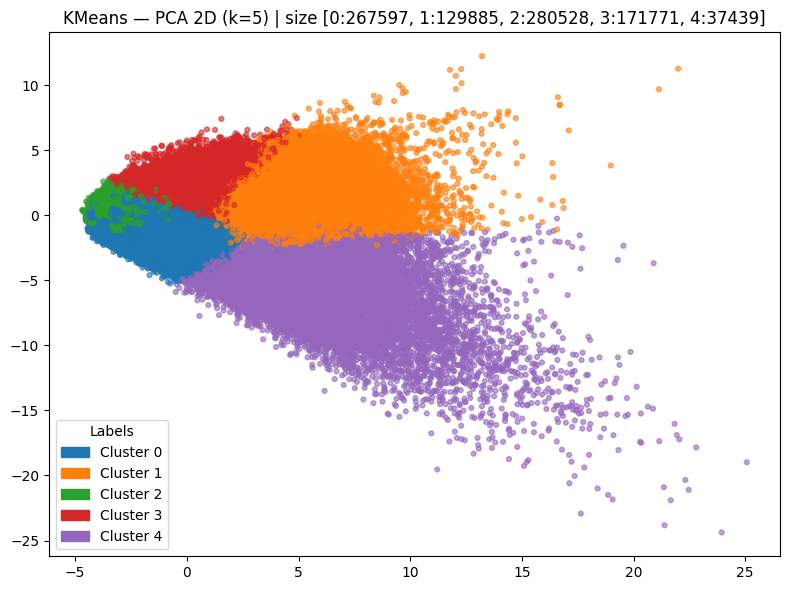

In [ ]:
# 2D visualization with PCA
# Fit PCA on the scaled features and project data to 2 principal components
pca = PCA(n_components=2)
reduced = pca.fit_transform(df_scaled)

# Select the base colormap "tab10"
base_cmap = plt.colormaps["tab10"]

# Take only the first 'num_clusters' colors
colors = base_cmap.colors[:num_clusters]

# Create a discrete colormap with these selected colors
cmap = ListedColormap(colors)

# Scatter plot of the 2D projection, colored by KMeans cluster labels
plt.figure(figsize=(8,6))
sc1 = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap=cmap, alpha=0.6, s=12)

# Get the unique cluster IDs found by KMeans
unique_clusters = np.unique(labels)

# Create a colored patch for each cluster
colors = [cmap(i) for i in range(num_clusters)]
patches = [mpatches.Patch(color=colors[i], label=f'Cluster {cl}')
           for i, cl in enumerate(unique_clusters)]

# Add the legend to the plot
plt.legend(handles=patches, title="Labels", loc='lower left', frameon=True)

# Compute cluster sizes to display in the title
sizes = np.bincount(labels)
sizes_txt = ", ".join(f"{i}:{sizes[i]}" for i in range(len(sizes)))

# Title with k, variance explained by PCs, and cluster sizes
plt.title(f'KMeans — PCA 2D (k={num_clusters}) | size [{sizes_txt}]')

plt.tight_layout()
plt.show()

**How to Read the Plot**
- The PC1 and PC2 axes are linear combinations of the original features that capture the largest share of variance.
- *Colors = clusters:*
  - if we see well-separated “islands” of a single color, it means that cluster is cohesive and distant from others even in 2D projection.
  - If different colors overlap, the separation between clusters is weak (at least in the first two components).
- *Cluster imbalance:*  overeall, you can see that some clusters are very large, while others are tiny (e.g., a cluster with very few points).

  This is typical of KMeans: dense groups may be split into sub-clusters, while rare cases/outliers can form micro-clusters (or be absorbed by larger ones).
- *Isolated points/outliers:* points far from the main “core” indicate atypical observations.

**What This Figure Tells Us**
- There is a large central mass with multiple colors --> the main clusters partially overlap in 2D, so the separation is not sharp in the first two components.
- This picture aligns with the contingency results: frequent classes (Good, Moderate) are split, while rare classes do not “emerge” as dedicated clusters.

### Visualization of Real Labels distribution
We will plot the distribution of rows of the dataste.

/tmp/ipython-input-1222565174.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  status_labels = df['status'].replace({'Moderate': 0, 'Good': 1, 'Unhealthy for Sensitive Groups': 2, 'Unhealthy': 3, 'Very Unhealthy': 4}, inplace=False).infer_objects(copy=False)


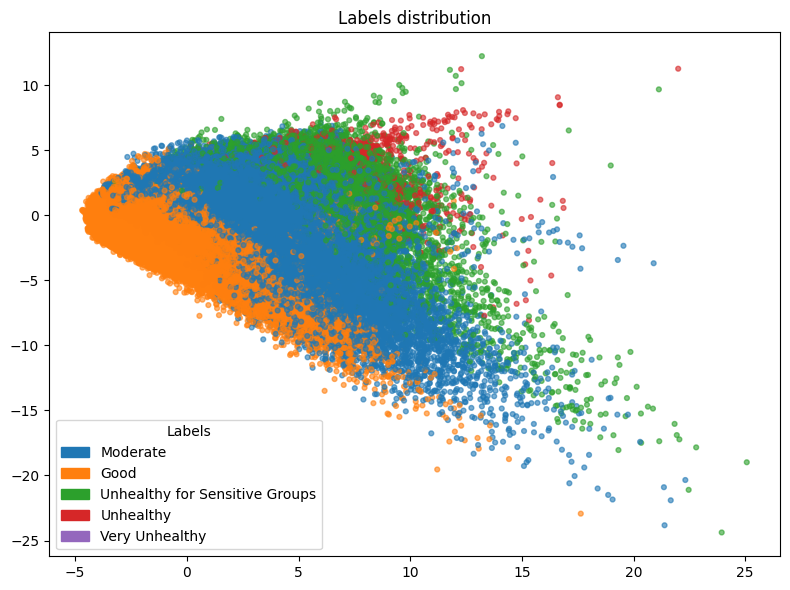

In [ ]:
status_labels = df['status'].replace({'Moderate': 0, 'Good': 1, 'Unhealthy for Sensitive Groups': 2, 'Unhealthy': 3, 'Very Unhealthy': 4}, inplace=False).infer_objects(copy=False)

# Scatter plot of the 2D projection, colored by KMeans cluster labels
plt.figure(figsize=(8,6))
sc1 = plt.scatter(reduced[:,0], reduced[:,1], c=status_labels, cmap=cmap, alpha=0.6, s=12)

# Create a colored patch for each cluster
colors = [cmap(i) for i in range(num_clusters)]
patches = [mpatches.Patch(color=colors[i], label=cl)
           for i, cl in enumerate(df['status'].unique())]

# Add the legend to the plot
plt.legend(handles=patches, title="Labels", loc='lower left', frameon=True)

# Title with k, variance explained by PCs, and cluster sizes
plt.title(f'Labels distribution')

plt.tight_layout()
plt.show()

### Comparison Between Clusters and True Labels
To visually assess the quality of clustering, we apply PCA (Principal Component Analysis) and project the data onto the first two principal components (PC1 and PC2).
- Each point represents a record from the dataset.
  - Orange color = the cluster assigned by KMeans matches the actual status value (match).
  - Red color = the cluster does not match the status value (mismatch).


**Interpretation:**

- Orange areas highlight where KMeans clusters align with the true classes --> indicating good overlap between the geometric structure and the known labels.
- Red areas show where clustering diverges from the status classes.
- The overall match accuracy (≈70%) suggests that KMeans does not perfectly reconstruct the 6 true categories, but still identifies a partially coherent structure.

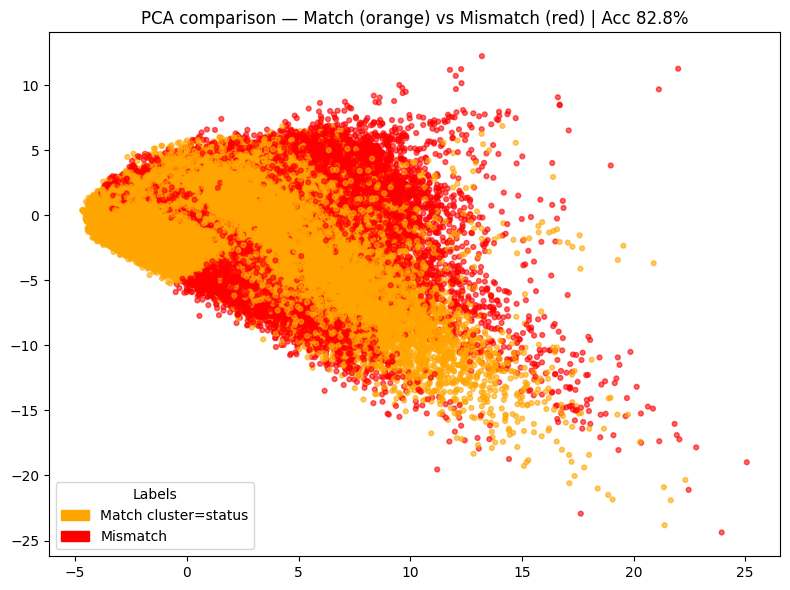

In [ ]:
# Color points by correctness: 'orange' if cluster --> status mapping matches the true status, else 'red'
colors = np.where(is_correct.values, 'orange', 'red')

#  2D PCA scatter colored by match/mismatch
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], c=colors, alpha=0.6, s=12)

# Legend using colored patches
patches = [
    mpatches.Patch(color='orange', label='Match cluster=status'),
    mpatches.Patch(color='red', label='Mismatch')
]
plt.legend(handles=patches, title="Labels", loc='lower left', frameon=True)

# Title shows overall accuracy computed earlier; axis labels include variance explained by PCs
plt.title(f'PCA comparison — Match (orange) vs Mismatch (red) | Acc {overall_acc*100:.1f}%')

plt.tight_layout()
plt.show()

## 6. Cluster Analysis: Mean Values of Variables
After assigning each record to a cluster, we can calculate the average of the numerical variables within each group.
This gives us a sort of “profile” of the cluster, describing its main characteristics.
- Each row represents a cluster found by KMeans.
- Each column shows the average value of that variable among the samples belonging to the cluster.
- By comparing values across clusters, we can understand what differentiates one group from another.
- For example, a cluster might have higher average values of PM2.5 and PM10, indicating more polluted areas or time periods.
- Another cluster might be characterized by elevated levels of O3 or by specific weather conditions (windspeed, winddirec).


In [ ]:
# Attach cluster assignments to the original data for interpretation
df_with_clusters = df.copy()
df_with_clusters["Cluster"] = labels

# Compute per-cluster averages
# This summarizes each cluster's centroid in the original feature space,
# which is easier to interpret than scaled values.
cluster_summary = df_with_clusters.groupby('Cluster').mean(numeric_only=True)

# Display the table
display(cluster_summary)

,so2,co,o3,o3_8hr,pm10,pm2.5,no2,nox,no,windspeed,winddirec,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude
Cluster,,,,,,,,,,,,,,,,,
0,0.869109,0.255146,25.674747,26.295047,18.154680,9.211284,8.645361,10.478552,1.790976,1.814770,147.165021,0.214060,9.472156,18.283206,0.394679,121.363059,24.910592
1,2.042823,0.423793,30.656244,32.465815,54.019825,29.110321,14.824228,16.743581,1.879188,1.445227,182.435678,0.362473,27.584512,51.547546,1.348547,120.487721,23.478380
2,0.975210,0.178665,22.070692,22.753252,17.866434,7.699531,5.364460,6.749649,1.346766,1.803212,176.553218,0.133283,7.983414,18.004267,0.566713,120.445440,23.282763
3,1.352045,0.263711,49.870789,46.409380,36.202525,17.257721,6.717558,7.739303,0.983950,2.786498,177.600491,0.230154,17.605670,35.851744,0.865181,120.652209,23.995823
4,1.463351,0.716641,13.014170,17.573104,32.116803,18.218489,26.042135,40.911587,14.824640,0.894623,168.010684,0.537191,16.905919,29.479019,0.791314,121.235877,24.711009


## Exercise 1
Group the classes considering the following logic:

1. `poor` quality for Very Unhealthy, Unhealthy, and Unhealthy for Sensitive Groups

2. `moderate` quality

3. `good` quality

Then run KMeans to find 3 clusters and associate a class to each cluster.

Finally, compute the accuracy considering this grouping.

BONUS: plot the distribution of labels in a 2D space (use PCA data already computed)

In [ ]:
status_column = df['status'].copy()

In [ ]:
# Grouping Logic

# Replace in status column

# Show the distinct values of the 'status' column

# Count how many unique labels/classes are present in 'status'

# Create a KMeans model with k = 3 clusters.

# Fit the model on the standardized numeric features and assign each sample to its nearest centroid.

# Build a contingency table between the true labels ('status')
# and the unsupervised cluster assignments 'labels'.

# For each cluster, pick the most frequent 'status'.

# Compute accuracy

#### Solution

In [ ]:
status_column = df['status'].copy()

# Grouping Logic
logic = {
            "Very Unhealthy": "Poor",
            "Unhealthy": "Poor",
            "Unhealthy for Sensitive Groups": "Poor"
        }

status_column.replace(logic, inplace=True)

# Show the distinct values of the 'status' column
print(status_column.unique())

# Count how many unique labels/classes are present in 'status'
num_clusters_ex1 = status_column.nunique()

# Create a KMeans model with k = num_clusters clusters.
kmeans = KMeans(n_clusters=num_clusters_ex1, n_init=10)
# Fit the model on the standardized numeric features and assign each sample to its nearest centroid.
labels_ex1 = kmeans.fit_predict(df_scaled)

# Build a contingency table between the true labels ('status')
# and the unsupervised cluster assignments 'labels'.
ct_ex1 = pd.crosstab(status_column, labels_ex1, colnames=['cluster'])
print("Contingency: status vs cluster")
display(ct_ex1)

# For each cluster, pick the most frequent 'status'.
# This yields a majority-vote mapping: cluster_id --> predicted status label.
cluster_to_status_ex1 = ct_ex1.idxmax(axis=0).to_dict()
print("Mapping cluster --> status:", cluster_to_status_ex1)

# Convert each sample's cluster id into a predicted status via the majority-vote mapping.
# Align the Series index with df to keep row order consistent.
pred_status_ex1 = pd.Series(labels_ex1, index=df.index).map(cluster_to_status_ex1)

# Compare predicted status vs. true status, elementwise; boolean Series of correct predictions.
is_correct_ex1 = pred_status_ex1.eq(status_column)

# Summarize performance per true status:
#  number of correct predictions
#  total samples
summary_ex1 = (
    pd.DataFrame({'status': status_column, 'correct': is_correct_ex1})
      .groupby('status')['correct']
      .agg(correct='sum', tot='count')
)

# Add errors and per-class accuracy (%).
summary_ex1['incorrect'] = summary_ex1['tot'] - summary_ex1['correct']
summary_ex1['accuracy_%'] = (summary_ex1['correct'] / summary_ex1['tot'] * 100).round(2)

print("\nSummary by status (correct/incorrect/accuracy):")
display(summary_ex1.sort_values('accuracy_%', ascending=False))

# Overall accuracy = mean correctness across all samples.
overall_acc_ex1 = is_correct_ex1.mean()
print(f"Global accuracy (cluster --> status): {overall_acc_ex1*100:.2f}%")

['Moderate' 'Good' 'Poor']
Contingency: status vs cluster


cluster,0,1,2
status,,,
Good,20373,514034,35829
Moderate,185796,61787,37031
Poor,29293,291,2786


Mapping cluster --> status: {0: 'Moderate', 1: 'Good', 2: 'Moderate'}

Summary by status (correct/incorrect/accuracy):


,correct,tot,incorrect,accuracy_%
status,,,,
Good,514034,570236,56202,90.14
Moderate,222827,284614,61787,78.29
Poor,0,32370,32370,0.00


Global accuracy (cluster --> status): 83.05%


**BONUS**
Plotting the distribution of the labels in a 2D space we can see that the clouds of points overlap, demonstrating that it is really difficult to clusterize this dataset.

/tmp/ipython-input-3295840794.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  status_labels_ex1 = status_column.replace({'Moderate': 0, 'Good': 1, 'Poor': 2}, inplace=False).infer_objects(copy=False)


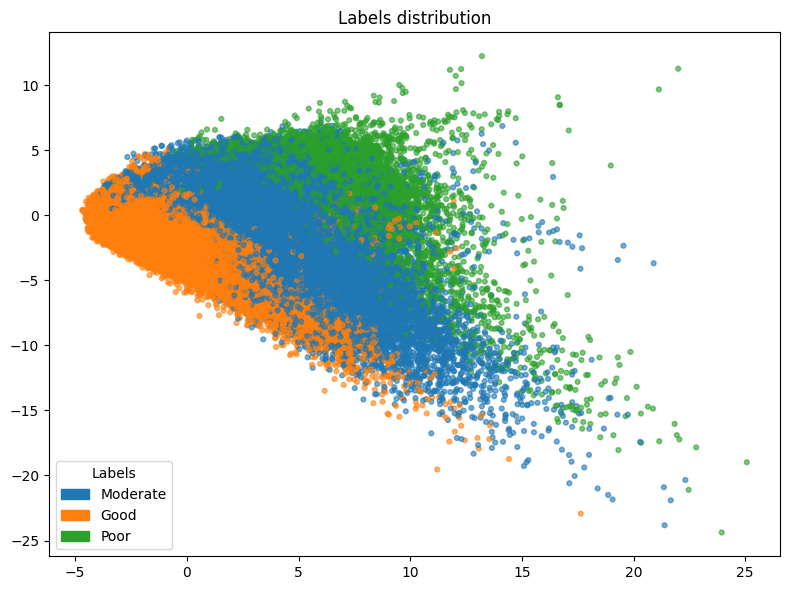

In [ ]:
status_labels_ex1 = status_column.replace({'Moderate': 0, 'Good': 1, 'Poor': 2}, inplace=False).infer_objects(copy=False)

# Select the base colormap "tab10"
base_cmap = plt.colormaps["tab10"]

# Take only the first 'num_clusters' colors
colors = base_cmap.colors[:num_clusters_ex1]

# Create a discrete colormap with these selected colors
cmap = ListedColormap(colors)

# Scatter plot of the 2D projection, colored by KMeans cluster labels
plt.figure(figsize=(8,6))
sc1 = plt.scatter(reduced[:,0], reduced[:,1], c=status_labels_ex1, cmap=cmap, alpha=0.6, s=12)

# Create a colored patch for each cluster
colors = [cmap(i) for i in range(num_clusters_ex1)]
patches = [mpatches.Patch(color=colors[i], label=cl)
           for i, cl in enumerate(status_column.unique())]

# Add the legend to the plot
plt.legend(handles=patches, title="Labels", loc='lower left', frameon=True)

# Title with k, variance explained by PCs, and cluster sizes
plt.title(f'Labels distribution')

plt.tight_layout()
plt.show()